In [2]:
import os
import sys
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../")
from common import make_env, get_frame_skip_and_timestep
from evals import eval_TD_error_increasing_force

sys.path.append("../../")
import TD3

In [2]:
# Hyperparameters to consider
response_times = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
g_forces = [5, 10]
seeds = [0, 1, 2, 3, 4]

# Ensure all runs exist
for response_rate in response_times:
    for g_force in g_forces:
        for seed in seeds:
            if not os.path.isfile('../models3/TD3_InvertedPendulum-v2_'+str(seed)+'_0.02_'+str(float(g_force))+'_'+str(response_rate)+'_1.0_True_256_final_actor'):
                print(f"Missing run: {response_rate, g_force, seed}")

In [3]:
df = pd.DataFrame(columns=["seed", "g_force", "response_rate", "eval_episode_num", "total_reward", "timestep", "time", "TD_error_1", "TD_error_2"])

# Environment hyperparameters
default_timestep = 0.02
default_frame_skip = 2
jit_duration = 0.02
env_name = "InvertedPendulum-v2"
delayed_env = True

# Experiment hyperparameters
CRITIC_RESPONSE_RATE = 0.02
if CRITIC_RESPONSE_RATE not in response_times: raise ValueError
NUM_EVAL_EPISODES = 10
STANDARDIZED_RESPONSE_RATE = 0.04

for i, g_force in enumerate(g_forces):
    print(f"G Force: {i+1}/{len(g_forces)}")
    for j, seed in enumerate(seeds):
        print(f"    - Seed: {j+1}/{len(seeds)}")

        # --- Load evaluation action-value function (critic) --- #

        # Get environment hyperparameters
        frame_skip, timestep, jit_frames = get_frame_skip_and_timestep(jit_duration, CRITIC_RESPONSE_RATE)
        time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
        temp_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
        temp_env.env.env._max_episode_steps = 100000
        state_dim = temp_env.observation_space[0].shape[0]
        action_dim = temp_env.action_space.shape[0]
        max_action = float(temp_env.action_space.high[0])
        
        # Initialise critic class
        kwargs = {
            "state_dim": state_dim,
            "action_dim": action_dim,
            "observation_space": temp_env.observation_space,
            "max_action": max_action,
            "discount": 0.99,
            "tau": 0.005,
            "delayed_env": delayed_env
        }
        kwargs["policy_noise"] = 2 * max_action
        kwargs["noise_clip"] = 0.5 * max_action
        kwargs["policy_freq"] = 2
        critic = TD3.TD3(**kwargs)

        # Load critic parameters
        arguments = ["TD3", env_name, seed, jit_duration, float(g_force), CRITIC_RESPONSE_RATE, 1.0, delayed_env, 256, "best"]
        file_name = '_'.join([str(x) for x in arguments])
        if os.path.exists('../models3/'+file_name+"_critic"):
            critic.load(f"../models3/{file_name}")
        else:
            raise FileNotFoundError

        del temp_env

        # --- Evaluate agents of various response times --- #

        for response_rate in response_times:

            # Determine reward scale factor (for 40ms standardized reward)
            REWARD_SCALE_FACTOR = response_rate / STANDARDIZED_RESPONSE_RATE
            Q_SCALE_FACTOR = CRITIC_RESPONSE_RATE / STANDARDIZED_RESPONSE_RATE

            # Get environment hyperparameters
            frame_skip, timestep, jit_frames = get_frame_skip_and_timestep(jit_duration, response_rate)
            time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
            eval_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
            eval_env.env.env._max_episode_steps = 100000
            state_dim = eval_env.observation_space[0].shape[0]
            action_dim = eval_env.action_space.shape[0]
            max_action = float(eval_env.action_space.high[0])
            
            # Initialise policy class
            kwargs = {
                "state_dim": state_dim,
                "action_dim": action_dim,
                "observation_space": eval_env.observation_space,
                "max_action": max_action,
                "discount": 0.99,
                "tau": 0.005,
                "delayed_env": delayed_env
            }
            kwargs["policy_noise"] = 2 * max_action
            kwargs["noise_clip"] = 0.5 * max_action
            kwargs["policy_freq"] = 2
            policy = TD3.TD3(**kwargs)

            # Load policy parameters
            arguments = ["TD3", env_name, seed, jit_duration, float(g_force), response_rate, 1.0, delayed_env, 256, "best"]
            file_name = '_'.join([str(x) for x in arguments])
            if os.path.exists('../models3/'+file_name+"_critic"):
                policy.load(f"../models3/{file_name}")
            else:
                raise FileNotFoundError

            # Evaluate policy and record TD error over episode
            evaluation_data = eval_TD_error_increasing_force(critic, policy, env_name, NUM_EVAL_EPISODES, time_change_factor, timestep, frame_skip, jit_frames, response_rate, delayed_env, None, REWARD_SCALE_FACTOR, Q_SCALE_FACTOR)

            for eval_episode_num, episode_data in evaluation_data.items():
                total_reward = episode_data[0]
                episode_TD_error_1 = episode_data[1]
                episode_TD_error_2 = episode_data[2]
                assert len(episode_TD_error_1) == len(episode_TD_error_2)
                for episode_timestep in range(len(episode_TD_error_1)):
                    df.loc[len(df.index)] = [seed, g_force, response_rate, eval_episode_num, total_reward, 
                                             (episode_timestep + 1), (episode_timestep + 1) * response_rate, 
                                             episode_TD_error_1[episode_timestep], 
                                             episode_TD_error_2[episode_timestep]
                                            ]

G Force: 1/2
    - Seed: 1/5
    - Seed: 2/5


Error: Canceled future for execute_request message before replies were done

In [ ]:
# torch.save(df, "dataframe_TD_error")

In [3]:
df = torch.load("dataframe_TD_error")

In [4]:
df["seconds_survived"] = df["total_reward"] * 0.04

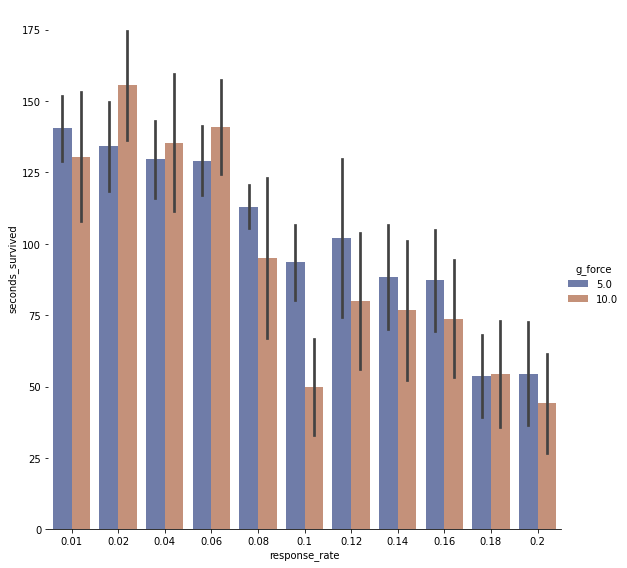

In [5]:
g = sns.catplot(data=df, kind="bar", x="response_rate", y="seconds_survived", ci="sd", hue="g_force", palette="dark", alpha=0.6, height=8)
g.despine(left=True)
g.set_axis_labels("response_rate", "seconds_survived")
plt.show()

### TD Error over Episode 

In [7]:
sns.set(rc={'figure.figsize':(14,10)})
sns.set_theme(style="whitegrid")

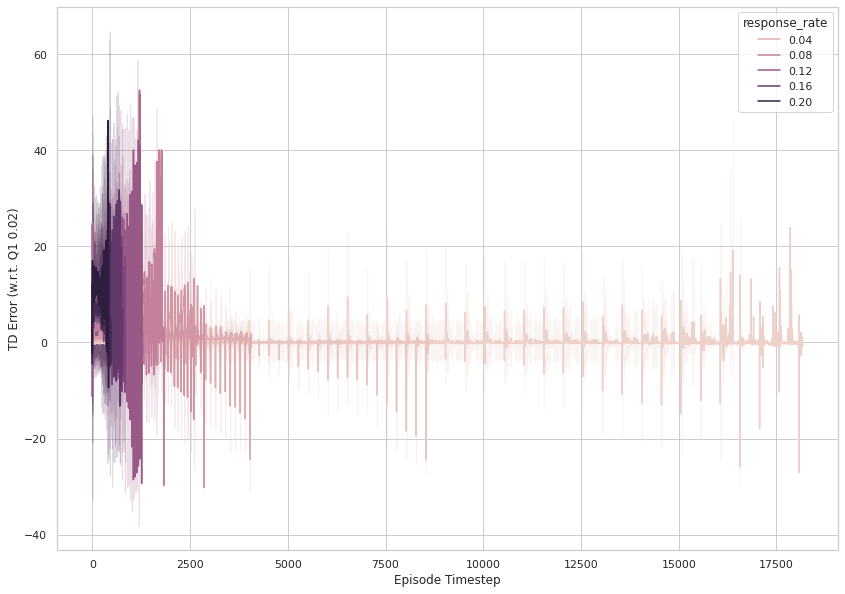

In [8]:
ax = sns.lineplot(data=df, x="timestep", y="TD_error_1", hue="response_rate", ci="sd")
ax.set(xlabel="Episode Timestep", ylabel="TD Error (w.r.t. Q1 0.02)")
plt.show()

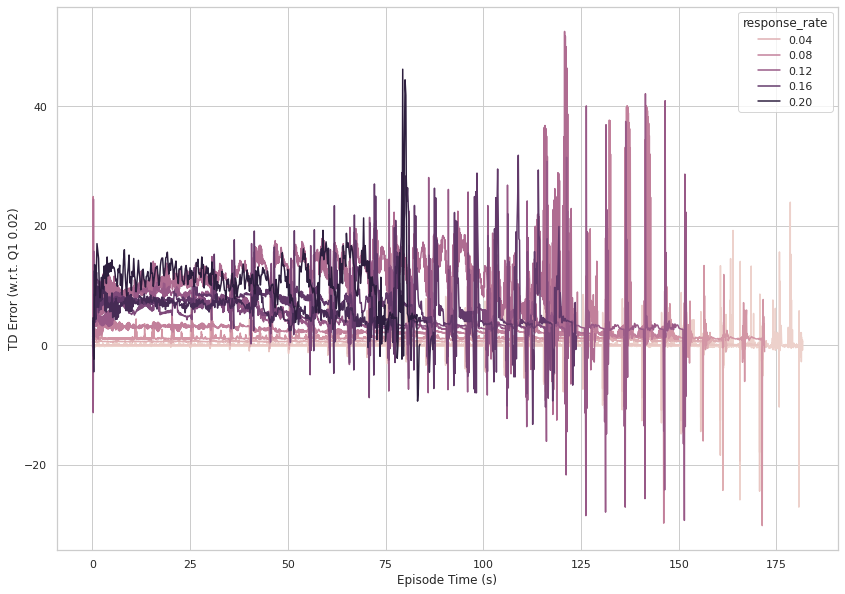

In [9]:
ax = sns.lineplot(data=df, x="time", y="TD_error_1", hue="response_rate", ci=None)
ax.set(xlabel="Episode Time (s)", ylabel="TD Error (w.r.t. Q1 0.02)")
plt.show()

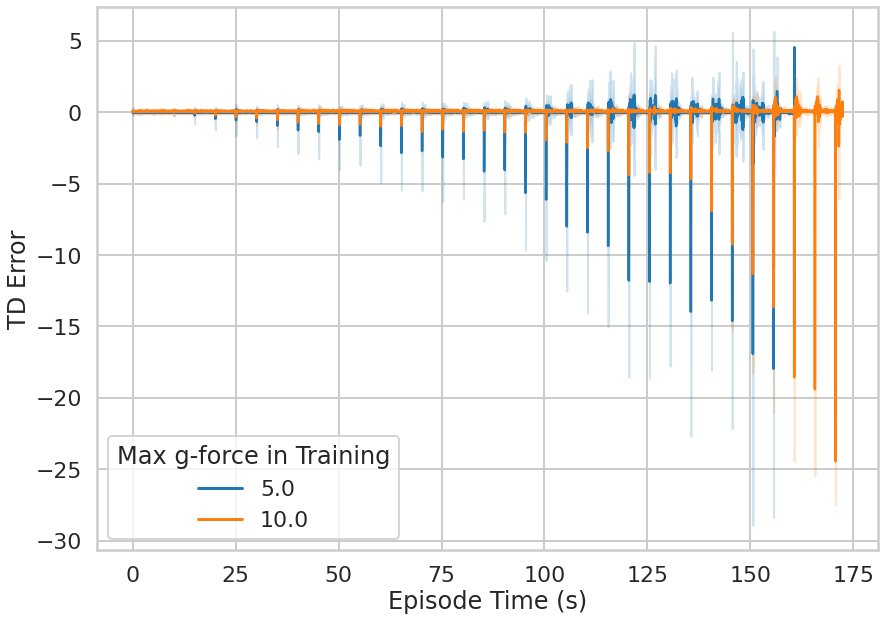

In [13]:
sns.set_theme(style="whitegrid", font_scale=2.5, palette="bright")
sns.set_context("poster")


df_20ms = df.loc[(df["response_rate"] == 0.02)]

ax = sns.lineplot(data=df_20ms, x="time", y="TD_error_1", hue="g_force", ci="sd", linewidth=2.5, palette="tab10")
ax.set(xlabel="Episode Time (s)", ylabel="TD Error")
plt.legend(title="Max g-force in Training", loc="lower left")
plt.show()

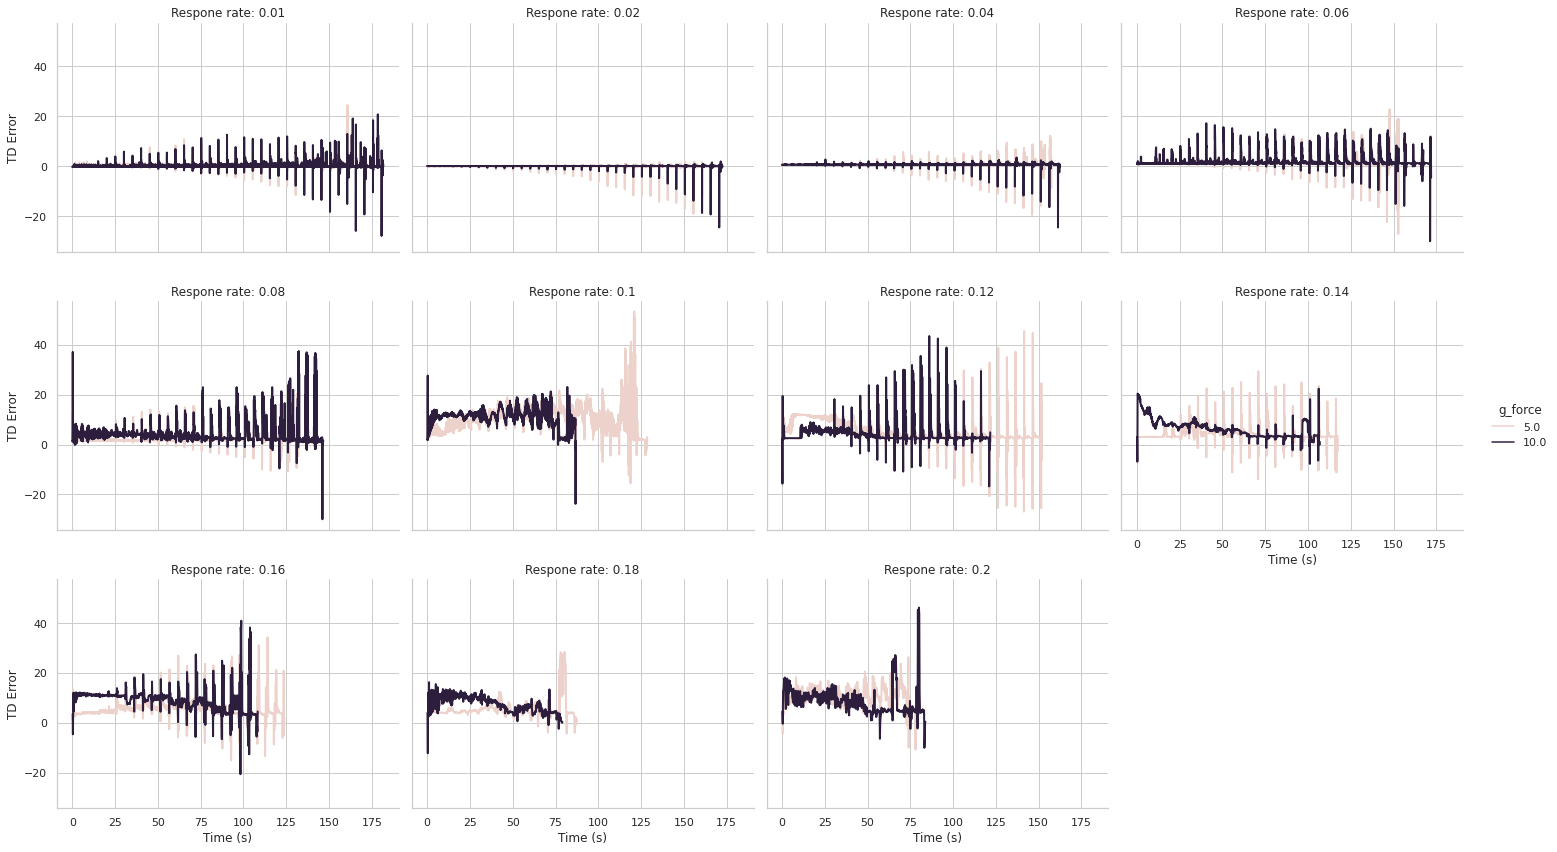

In [9]:
g = sns.relplot(
    data=df,
    x="time", y="TD_error_2", col="response_rate", hue="g_force",
    kind="line", linewidth=2, zorder=5,
    col_wrap=4, height=4, aspect=1.3, ci=None,
)
g.set_titles("Respone rate: {col_name}")
g.set_axis_labels("Time (s)", "TD Error")
g.tight_layout()

In [18]:
df

,seed,g_force,response_rate,eval_episode_num,total_reward,timestep,time,TD_error_1,TD_error_2,ABS_TD_Error_1,seconds_survived
0,0.0,5.0,0.01,0.0,3156.0,1.0,0.01,-0.036003,-0.033665,0.036003,126.24
1,0.0,5.0,0.01,0.0,3156.0,2.0,0.02,-0.030676,-0.012514,0.030676,126.24
2,0.0,5.0,0.01,0.0,3156.0,3.0,0.03,-0.014469,-0.012838,0.014469,126.24
3,0.0,5.0,0.01,0.0,3156.0,4.0,0.04,-0.009003,-0.013730,0.009003,126.24
4,0.0,5.0,0.01,0.0,3156.0,5.0,0.05,-0.020010,-0.013258,0.020010,126.24
...,...,...,...,...,...,...,...,...,...,...,...
2964729,4.0,10.0,0.20,9.0,195.0,34.0,6.80,90.137807,97.818920,90.137807,7.80
2964730,4.0,10.0,0.20,9.0,195.0,35.0,7.00,-26.333286,59.552659,26.333286,7.80
2964731,4.0,10.0,0.20,9.0,195.0,36.0,7.20,59.668054,-28.425854,59.668054,7.80
2964732,4.0,10.0,0.20,9.0,195.0,37.0,7.40,-62.087109,32.092472,62.087109,7.80


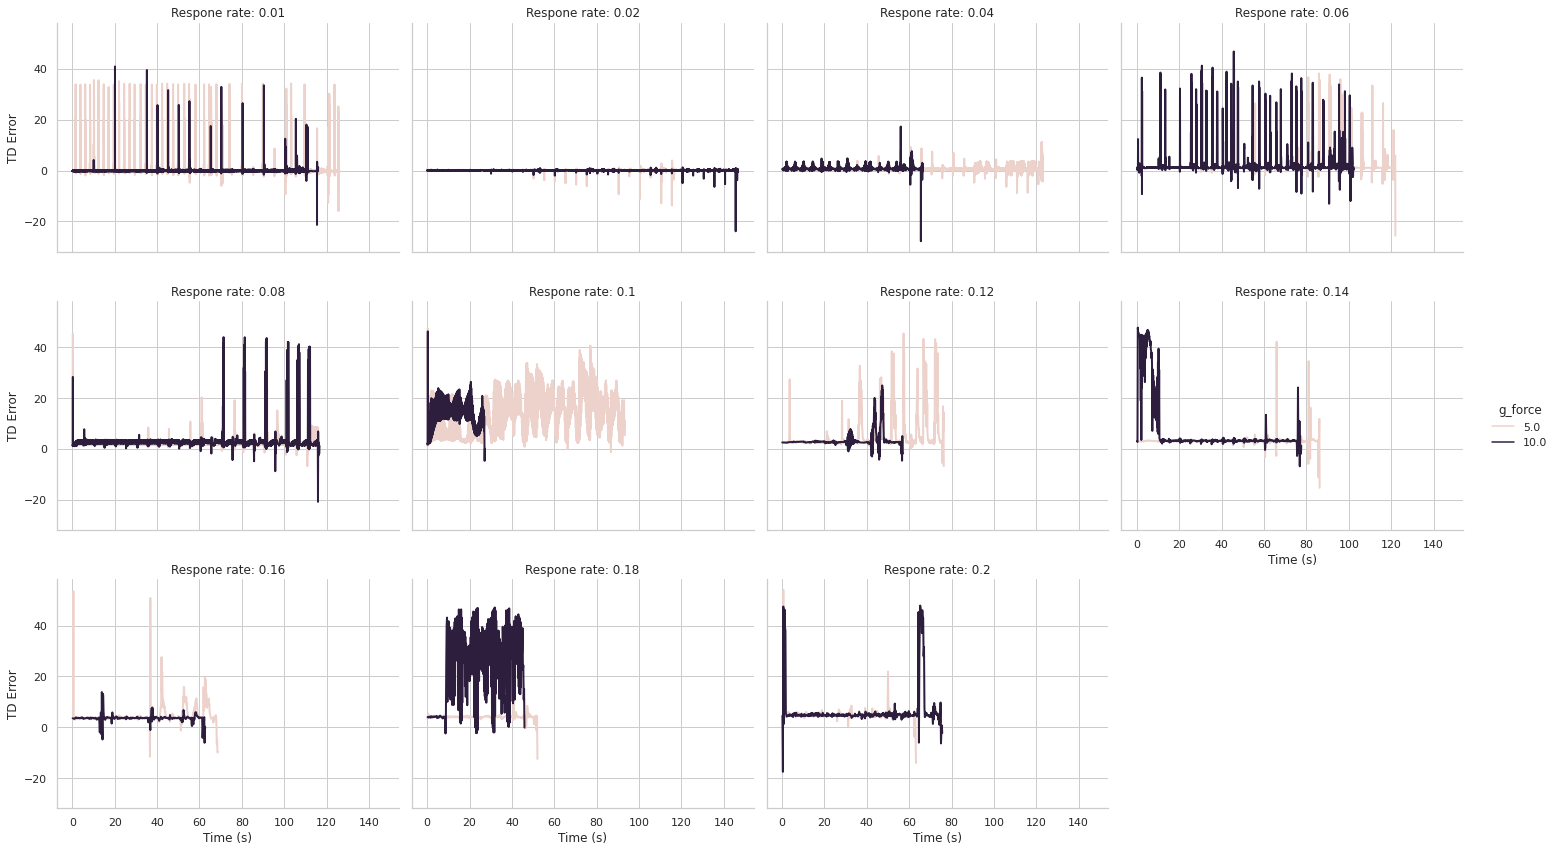

In [9]:
df_single = df.loc[(df["seed"] == 0.0) & (df["eval_episode_num"] == 0.0)]

g = sns.relplot(
    data=df_single,
    x="time", y="TD_error_1", col="response_rate", hue="g_force",
    kind="line", linewidth=2, zorder=5,
    col_wrap=4, height=4, aspect=1.3, ci=None,
)
g.set_titles("Respone rate: {col_name}")
g.set_axis_labels("Time (s)", "TD Error")
g.tight_layout()

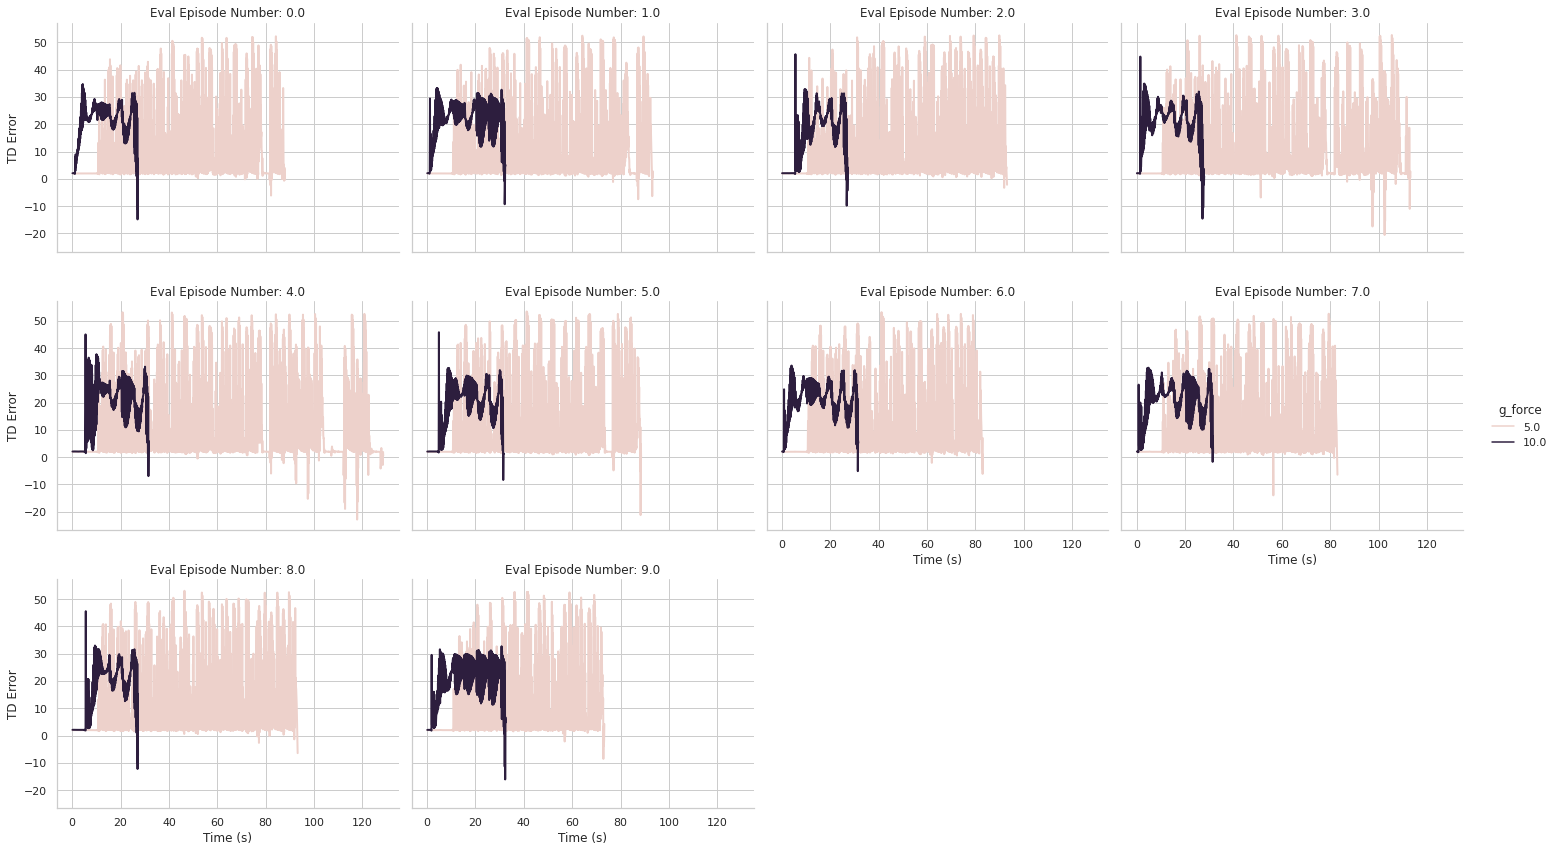

In [10]:
df_100ms= df.loc[(df["response_rate"] == 0.10) & (df["seed"] == 1.0)]

g = sns.relplot(
    data=df_100ms,
    x="time", y="TD_error_1", col="eval_episode_num", hue="g_force",
    kind="line", linewidth=2, zorder=5,
    col_wrap=4, height=4, aspect=1.3, ci=None,
)
g.set_titles("Eval Episode Number: {col_name}")
g.set_axis_labels("Time (s)", "TD Error")
g.tight_layout()

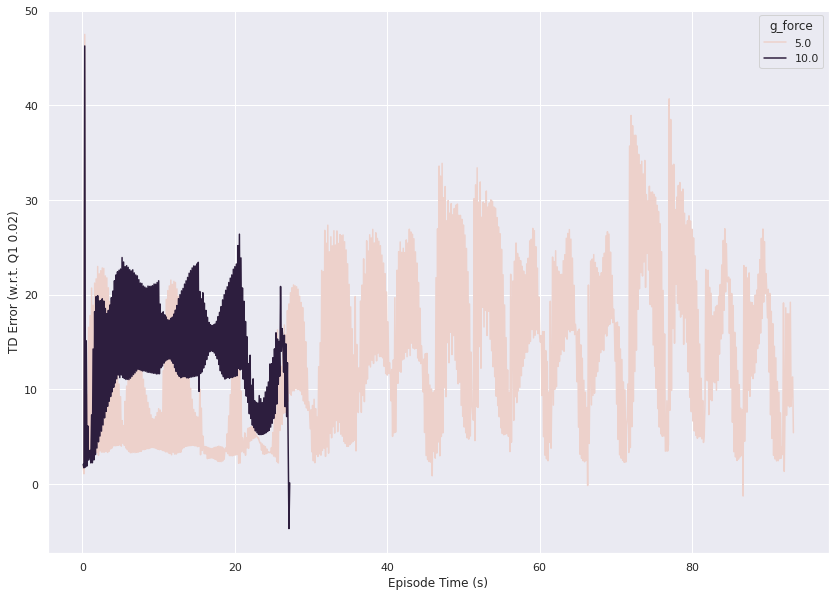

In [11]:
sns.set(rc={'figure.figsize':(14,10)})
df_100ms = df.loc[(df["response_rate"] == 0.1) & (df["seed"] == 0.0) & (df["eval_episode_num"] == 0.0)]

ax = sns.lineplot(data=df_100ms, x="time", y="TD_error_1", hue="g_force", ci="sd")
ax.set(xlabel="Episode Time (s)", ylabel="TD Error (w.r.t. Q1 0.02)")
plt.show()

In [32]:
df_100ms

,seed,g_force,response_rate,eval_episode_num,total_reward,timestep,time,TD_error_1,TD_error_2,seconds_survived,ABS_TD_Error_1
245243,0.0,5.0,0.1,0.0,2582.5,1.0,0.1,1.945403,2.008388,103.3,1.945403
245244,0.0,5.0,0.1,0.0,2582.5,2.0,0.2,-44.107983,-45.003267,103.3,44.107983
245245,0.0,5.0,0.1,0.0,2582.5,3.0,0.3,46.903281,45.010760,103.3,46.903281
245246,0.0,5.0,0.1,0.0,2582.5,4.0,0.4,2.290570,5.067760,103.3,2.290570
245247,0.0,5.0,0.1,0.0,2582.5,5.0,0.5,-5.170788,-5.203657,103.3,5.170788
...,...,...,...,...,...,...,...,...,...,...,...
1778514,0.0,10.0,0.1,0.0,422.5,164.0,16.4,3.390163,8.750837,16.9,3.390163
1778515,0.0,10.0,0.1,0.0,422.5,165.0,16.5,4.557733,2.798196,16.9,4.557733
1778516,0.0,10.0,0.1,0.0,422.5,166.0,16.6,-2.314583,-3.187739,16.9,2.314583
1778517,0.0,10.0,0.1,0.0,422.5,167.0,16.7,-1.018038,7.726200,16.9,1.018038


In [33]:
df_100ms.to_csv("df_100ms_seed-0_eval-ep-0")

In [17]:
# g_forces = [5, 10]
# seeds = [0, 1, 2, 3, 4]

# for g_force in g_forces:
#     for seed in seeds:
#         for eval_episode_num in range(10):
#             df_temp = df_10ms.loc[(df_10ms["g_force"] == float(g_force)) & (df_10ms["seed"] == float(seed)) & (df_10ms["eval_episode_num"] == float(eval_episode_num))]
#             print(f"- {g_force:2} {seed} {eval_episode_num}: {df_temp['time'].max()}")

### TD Error for Response Rates

In [12]:
sns.set_theme(style="whitegrid")

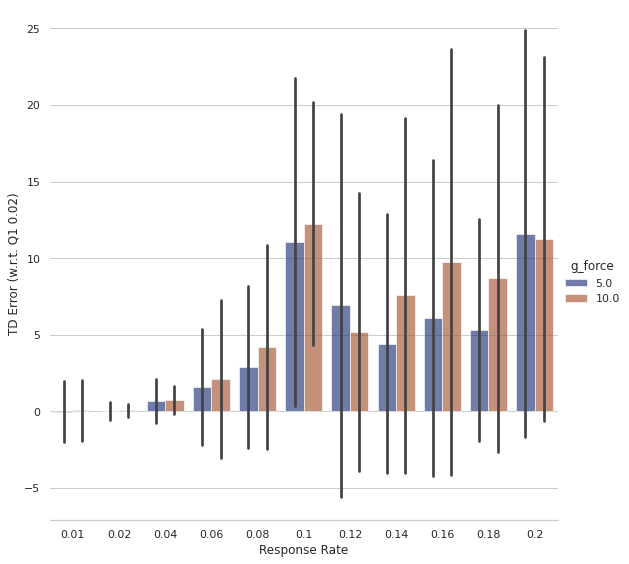

In [13]:
g = sns.catplot(data=df, kind="bar", x="response_rate", y="TD_error_1", ci="sd", hue="g_force", palette="dark", alpha=0.6, height=8)
g.despine(left=True)
g.set_axis_labels("Response Rate", "TD Error (w.r.t. Q1 0.02)")
plt.show()

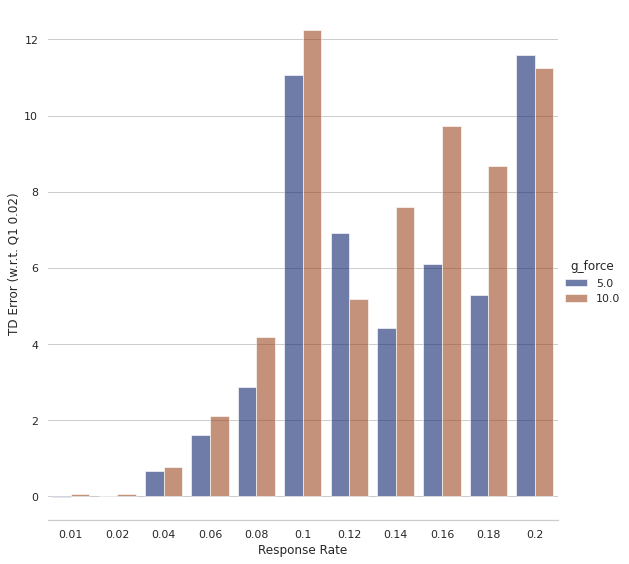

In [14]:
g = sns.catplot(data=df, kind="bar", x="response_rate", y="TD_error_1", ci=None, hue="g_force", palette="dark", alpha=0.6, height=8)
g.despine(left=True)
g.set_axis_labels("Response Rate", "TD Error (w.r.t. Q1 0.02)")
plt.show()

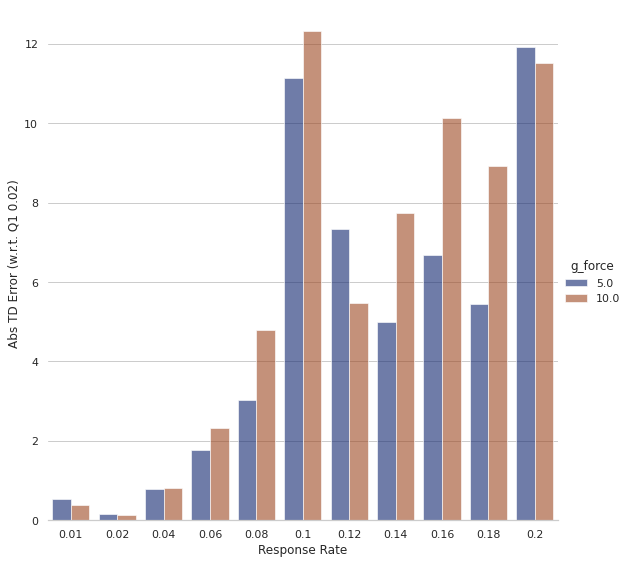

In [15]:
df["ABS_TD_Error_1"] = abs(df["TD_error_1"])
g = sns.catplot(data=df, kind="bar", x="response_rate", y="ABS_TD_Error_1", ci=None, hue="g_force", palette="dark", alpha=0.6, height=8)
g.despine(left=True)
g.set_axis_labels("Response Rate", "Abs TD Error (w.r.t. Q1 0.02)")
plt.show()